In [1]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, MaxPool2D, ReLU, Input, BatchNormalization, Concatenate, Lambda, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

In [2]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.10.1
1.21.6
4.8.0


In [3]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection  + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
#Global variable
W,H = 256, 256
CHANNEL = 3

In [5]:
with CustomObjectScope({'iou':iou, 'dice_coef':dice_coef, 'dice_loss':dice_loss}):
    model = tf.keras.models.load_model("./models/unet_for_skull_stripping.h5")

In [7]:
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img.astype(np.float32)
    return img

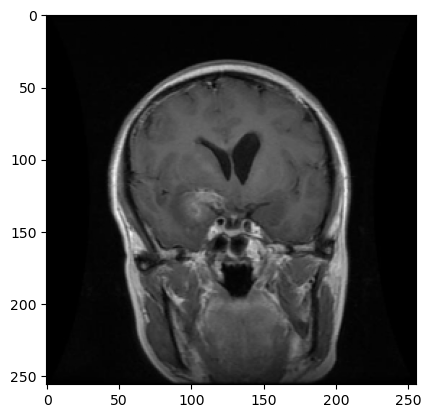

In [8]:
img = read_img('./testing_images/Te-gl_0044.jpg')
plt.imshow(img)

# Prediction

1/1 [==============================] - 4s 4s/step


Text(0.5, 0, 'PREDICTED MASK')

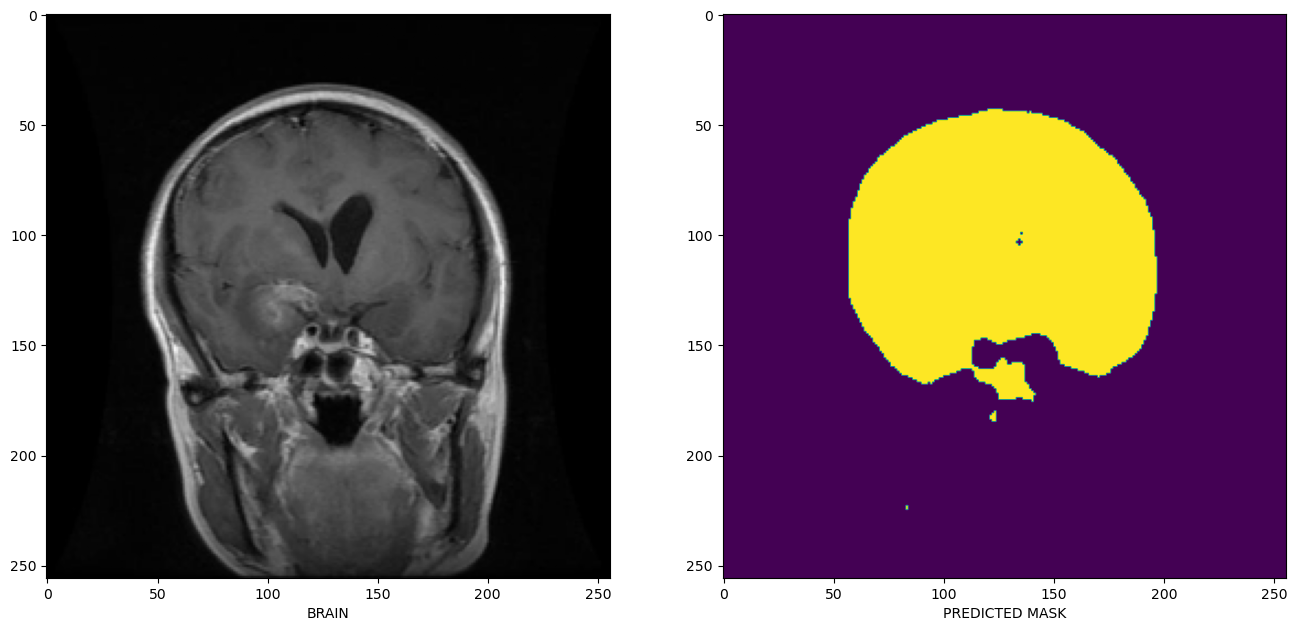

In [9]:
img_reshaped = img.reshape(1, 256, 256, 3)
pred = model.predict(img_reshaped)[0] > 0.5  
pred = pred.astype(np.int32)
pred_img = pred.reshape(256, 256, 1)
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(img)
ax[0].set_xlabel("BRAIN")
ax[1].imshow(pred_img)
ax[1].set_xlabel("PREDICTED MASK")

# Stripping the Skull

In [12]:
cv2.imwrite("./testing_images/mask-1.png", pred_img)

True

In [13]:
#read mask again
maskImg = cv2.imread("./testing_images/mask-1.png")
print(maskImg.shape)
maskImg = cv2.cvtColor(maskImg, cv2.COLOR_BGR2GRAY)
maskImg.shape

(256, 256, 3)


(256, 256)

In [15]:
masked = cv2.bitwise_and(img, img, mask=maskImg)

Text(0.5, 0, 'SKULL STRIPPED BRAIN')

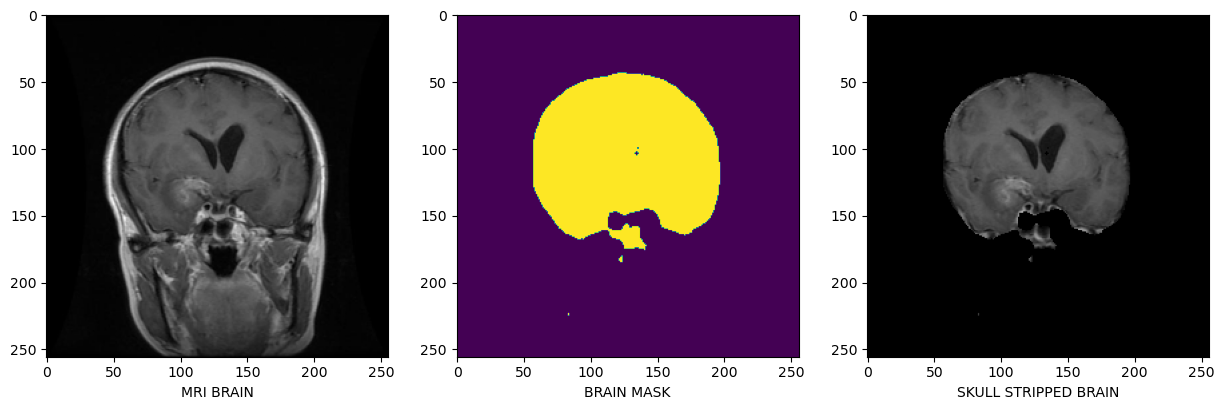

In [17]:
#visualize
fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(img)
ax[0].set_xlabel("MRI BRAIN")
ax[1].imshow(maskImg)
ax[1].set_xlabel("BRAIN MASK")
ax[2].imshow(masked)
ax[2].set_xlabel("SKULL STRIPPED BRAIN")